In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from patsy import dmatrices

import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.set_option('display.max_row',None)

In [5]:
# read and drop non-important columns
data = pd.read_csv('data/paris.csv')
data.set_index('id',inplace=True)

## Data Cleaning of the Explained Variable: Price

In [6]:
# data cleaning: price, transfer from str to float
data.dropna()
data.dropna(subset=["price"],inplace=True)
data["price"] = data["price"].str.replace(",", "")
data["price"] = data["price"].str.replace("$", "").astype("float")

# Have an Idea of the price datapoints
data.price.describe()

count    67108.000000
mean       221.161739
std        662.165493
min          8.000000
25%         86.000000
50%        129.000000
75%        205.000000
max      84420.000000
Name: price, dtype: float64

In [7]:
# Remove extreme values (3 sigma principle)
priceH = data.price.mean()+3*data.price.std()
priceL = data.price.mean()-3*data.price.std()

outliersH = data.loc[(data.price > priceH)]
outliersL = data.loc[(data.price < priceL)]

print('The outliers above 3 std of the mean have mean and std:')
OutliersH_stats = outliersH['price'].agg(['mean','std'])
display(OutliersH_stats)

print('The outliers below 3 std of the mean have mean and std:')
OutliersL_stats = outliersL['price'].agg(['mean','std'])
display(OutliersL_stats)

data = data.loc[(data.price < priceH) & (data.price > priceL) ]

The outliers above 3 std of the mean have mean and std:


mean    5269.735149
std     6290.611988
Name: price, dtype: float64

The outliers below 3 std of the mean have mean and std:


mean   NaN
std    NaN
Name: price, dtype: float64

In [8]:
# Have an Idea of the price datapoints
data.price.describe()

count    66704.000000
mean       190.584508
std        216.168587
min          8.000000
25%         86.000000
50%        128.000000
75%        200.000000
max       2201.000000
Name: price, dtype: float64

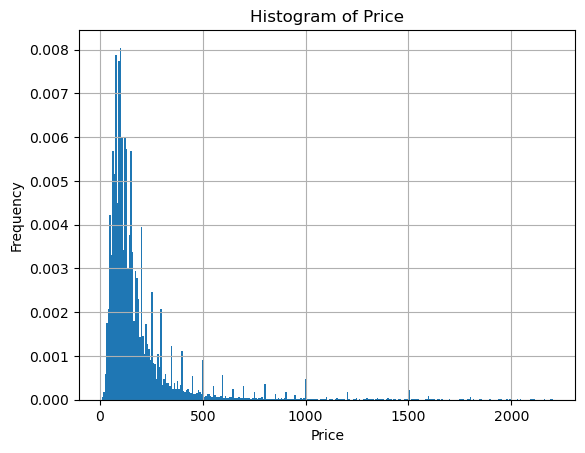

In [9]:
# plot histogram
plt.hist(data['price'], bins=300, density= True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Histogram of Price')
plt.show()

# We can see that we still have some outliers but it is important to keep some those that are realistic (in the +/- 3 std range) 
# because they are representative of the real estate market

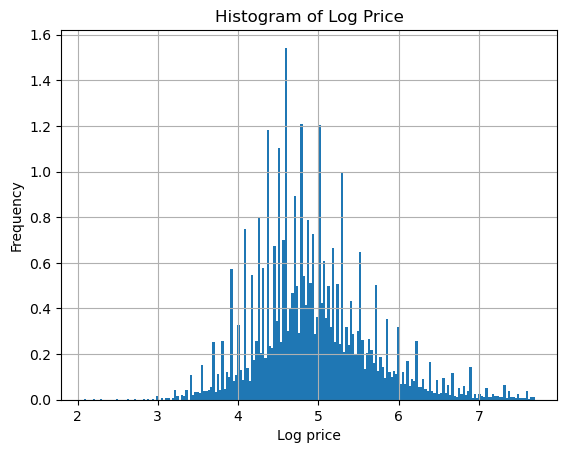

In [10]:
# calculate log price
data["ln_price"] = np.log(data.price)

# plot histogram
plt.hist(data['ln_price'], bins=200, density=True)
plt.xlabel('Log price')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Histogram of Log Price')
plt.show()

# Applying the log price allows us to have a distribution that is a bit more normal with thinner tails (more homoskedastic)

## Feature Selection

In [11]:
# See all of the features
original_data_columns_name = data.columns.tolist()
print(original_data_columns_name)
print(f'We have in total {len(original_data_columns_name)} columns')

['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_36

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
scrape_id,66704.0,2.023121e+13,1.428917e+01,2.023121e+13,2.023121e+13,2.023121e+13,2.023121e+13,2.023121e+13
description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,66704.0,1.602960e+08,1.807819e+08,2.750000e+02,1.678606e+07,6.178899e+07,2.990905e+08,5.503984e+08
host_listings_count,66700.0,2.906712e+01,1.044319e+02,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,2.822000e+03
host_total_listings_count,66700.0,4.083636e+01,1.511668e+02,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00,5.516000e+03
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,66704.0,4.886448e+01,1.809982e-02,4.881608e+01,4.885138e+01,4.886576e+01,4.887909e+01,4.890167e+01
longitude,66704.0,2.343843e+00,3.394767e-02,2.224640e+00,2.322500e+00,2.347330e+00,2.368860e+00,2.467120e+00
accommodates,66704.0,3.137188e+00,1.629928e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
features_to_remove = ['scrape_id','description', 'host_id','host_url','host_name','host_location','host_about','host_thumbnail_url','host_neighbourhood',
                      'host_picture_url','neighborhood_overview','picture_url','neighbourhood_group_cleansed','last_scraped', 'listing_url','source',
                      'name','license','minimum_minimum_nights','maximum_minimum_nights','maximum_nights','minimum_maximum_nights','maximum_maximum_nights',
                      'first_review','calendar_updated','calendar_last_scraped','last_review','amenities','bedrooms','bathrooms','latitude', 'longitude']

data.drop(features_to_remove,axis = 1,inplace = True)

## additional Info
# We kept: neighborhoods, 'minimum_nights_avg_ntm','maximum_nights_avg_ntm', host_verifications
# Before: features_to_remove = ['listing_url','scrape_id','last_scraped','source','name','description','neighborhood_overview','picture_url','host_id','host_url','host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_neighbourhood','neighbourhood','neighbourhood_group_cleansed','amenities','minimum_minimum_nights','maximum_minimum_nights','host_verifications','maximum_nights','first_review','last_review','bedrooms','bathrooms',
#'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','has_availability','calendar_last_scraped','license']

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
host_listings_count,66700.0,29.067121,1.044319e+02,1.000000,1.000000,1.00000,4.000000,2.822000e+03
host_total_listings_count,66700.0,40.836357,1.511668e+02,1.000000,1.000000,2.00000,6.000000,5.516000e+03
accommodates,66704.0,3.137188,1.629928e+00,1.000000,2.000000,2.00000,4.000000,1.600000e+01
beds,66077.0,1.756103,1.280475e+00,1.000000,1.000000,1.00000,2.000000,9.000000e+01
price,66704.0,190.584508,2.161686e+02,8.000000,86.000000,128.00000,200.000000,2.201000e+03
minimum_nights,66704.0,42.671669,1.086955e+02,1.000000,2.000000,3.00000,6.000000,1.000000e+03
minimum_nights_avg_ntm,66704.0,45.947642,1.120834e+02,1.000000,2.000000,3.00000,7.000000,1.000000e+03
maximum_nights_avg_ntm,66704.0,225293.673435,2.193311e+07,1.000000,90.000000,365.00000,1125.000000,2.147484e+09
availability_30,66704.0,8.598930,1.040751e+01,0.000000,0.000000,3.00000,16.000000,3.000000e+01
availability_60,66704.0,18.719297,2.209103e+01,0.000000,0.000000,7.00000,39.000000,6.000000e+01


### Neighborhoods

neighbourhood_cleansed
Buttes-Montmartre      7385
Popincourt             5934
Vaugirard              4995
Entrepôt               4726
Batignolles-Monceau    4484
Passy                  4006
Buttes-Chaumont        3864
Ménilmontant           3699
Opéra                  3293
Temple                 2949
Reuilly                2633
Observatoire           2458
Bourse                 2361
Hôtel-de-Ville         2190
Élysée                 2143
Gobelins               2127
Panthéon               2123
Luxembourg             1933
Palais-Bourbon         1850
Louvre                 1551
Name: count, dtype: int64


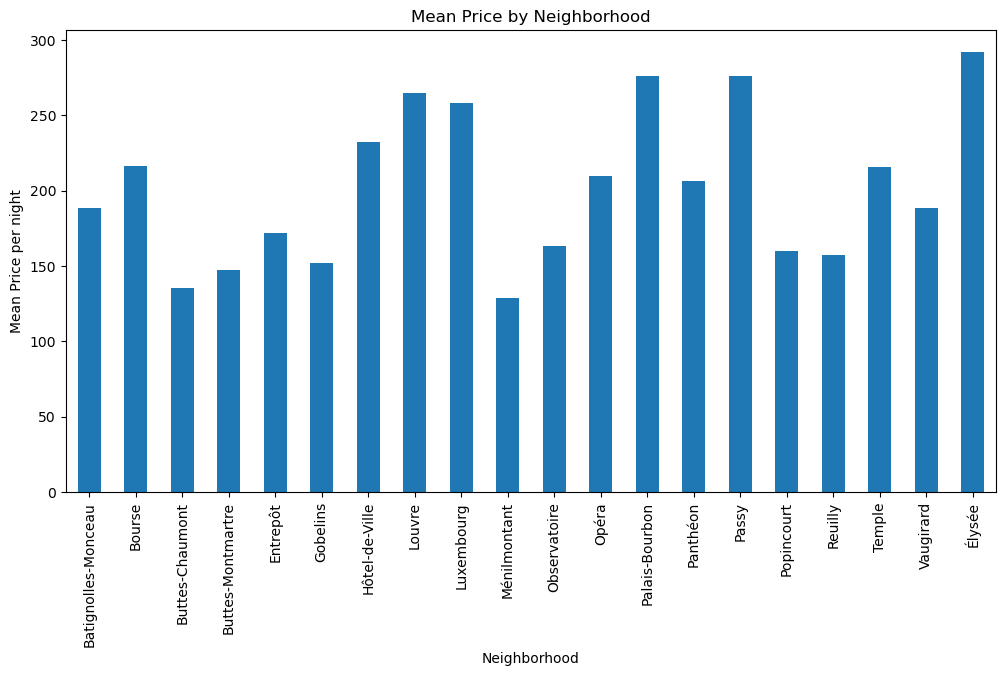

In [15]:
# Group dataset by neighborhood
grouped = data.groupby('neighbourhood_cleansed')
print(data.neighbourhood_cleansed.value_counts())

data.dropna(subset=["neighbourhood_cleansed"],inplace=True)

# Add a One hot Encoder for the neighborhoods

# Calculate the mean price for each neighborhood
mean_price = grouped['price'].mean()

# Plot the mean prices
plt.figure(figsize=(12, 6))
mean_price.plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Mean Price per night')
plt.title('Mean Price by Neighborhood')
plt.show()


# One-hot encode the 'neighbourhood_cleansed' column
one_hot_encoded = pd.get_dummies(data['neighbourhood_cleansed'])

# Concatenate the one-hot encoded columns with the original dataframe
data = pd.concat([data, one_hot_encoded], axis=1)

data_neighborhood_name = data.neighbourhood_cleansed.unique().tolist()
neighborhood_string = ' + '.join([name.replace('-', '_') for name in data_neighborhood_name])

new_column_names = [col.replace('-', '_') for col in data.columns]
data.columns = new_column_names

# Drop the original 'neighbourhood_cleansed' column
data.drop('neighbourhood_cleansed', axis=1, inplace=True)




In [16]:
print(neighborhood_string)


Observatoire + Hôtel_de_Ville + Entrepôt + Opéra + Vaugirard + Louvre + Luxembourg + Popincourt + Gobelins + Bourse + Buttes_Montmartre + Buttes_Chaumont + Temple + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Ménilmontant + Palais_Bourbon + Passy


In [17]:
# Simple Regression on the Neighborhoods:
# We should remove a base category here Buttes-Montmartre
simp_reg_neighborhoods = smf.ols(formula="ln_price ~ Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant", data=data).fit()
simp_reg_neighborhoods.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     335.7
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:43   Log-Likelihood:                -70344.
No. Observations:               66704   AIC:                         1.407e+05
Df Residuals:                   66684   BIC:                         1.409e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       4.7420      0.008    586.570      0.000       4.726       4.758
Observatoire[T.True]            0.0482      0.016      2.981      0.003       0.017       0.080
Hôtel_de_Ville[T.True]          0.4471      0.017     26.448      0.000       0.414       0.480
Entrepôt[T.True]                0.1382      0.013     10.682      0.000       0.113       0.164
Popincourt[T.True]              0.0792      0.012      6.542      0.000       0.055       0.103
Louvre[T.True]                  0.5823      0.019     30.007      0.000       0.544       0.620
Bourse[T.True]                  0.3971      0.016     24.174      0.000       0.365       0.429
Gobelins[T.True]               -0.0254      0.017     -1.488      0.137      -0.059       0.008
Luxembourg[T.True]              0.4997      0.018     28.150      0.000       0.465       0.534
Buttes_Chaumont[T.True]        -0.1123      0.014     -8.142      0.000      -0.139      -0.085
Reuilly[T.True]                 0.0166      0.016      1.055      0.292      -0.014       0.048
Élysée[T.True]                  0.5924      0.017     34.754      0.000       0.559       0.626
Panthéon[T.True]                0.3184      0.017     18.608      0.000       0.285       0.352
Batignolles_Monceau[T.True]     0.1648      0.013     12.530      0.000       0.139       0.191
Vaugirard[T.True]               0.1821      0.013     14.308      0.000       0.157       0.207
Opéra[T.True]                   0.3138      0.015     21.557      0.000       0.285       0.342
Palais_Bourbon[T.True]          0.5318      0.018     29.443      0.000       0.496       0.567
Passy[T.True]                   0.4716      0.014     34.592      0.000       0.445       0.498
Temple[T.True]                  0.3892      0.015     25.717      0.000       0.360       0.419
Ménilmontant[T.True]           -0.1346      0.014     -9.616      0.000      -0.162      -0.107
==============================================================================
Omnibus:                     5803.174   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8878.781
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                       4.173   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Room Type

In [18]:
# Unerstanding of the different values of Room Type
print(f'{data.room_type.value_counts()}')

data.dropna(subset=["room_type"],inplace=True)


room_type
Entire home/apt    58433
Private room        7141
Hotel room           721
Shared room          409
Name: count, dtype: int64


In [19]:
# Modify the Room Type column to an Entire Home column
data.rename(columns={'room_type': 'Entire_room'}, inplace=True)
data.Entire_room = [1 if x == "Entire home/apt" else 0 for x in data.Entire_room]
print(data.Entire_room.value_counts())
 
simp_reg_entire_rooms = smf.ols('ln_price ~ Entire_room', data=data).fit()
simp_reg_entire_rooms.summary()


Entire_room
1    58433
0     8271
Name: count, dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2138.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:43   Log-Likelihood:                -72338.
No. Observations:               66704   AIC:                         1.447e+05
Df Residuals:                   66702   BIC:                         1.447e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.5923      0.008    583.533      0.000       4.577       4.608
Entire_room     0.3888      0.008     46.243      0.000       0.372       0.405
==============================================================================
Omnibus:                     6624.081   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9522.361
Skew:                           0.779   Prob(JB):                         0.00
Kurtosis:                       4.001   Cond. No.                         5.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Beds

beds
17        1
90        1
85        1
77        1
79        1
83        1
15        2
18        2
13        4
12        7
10        8
11        8
9        29
8        80
7       132
6       391
5      1005
4      2818
3      6764
2     19656
1     35165
Name: count, dtype: int64


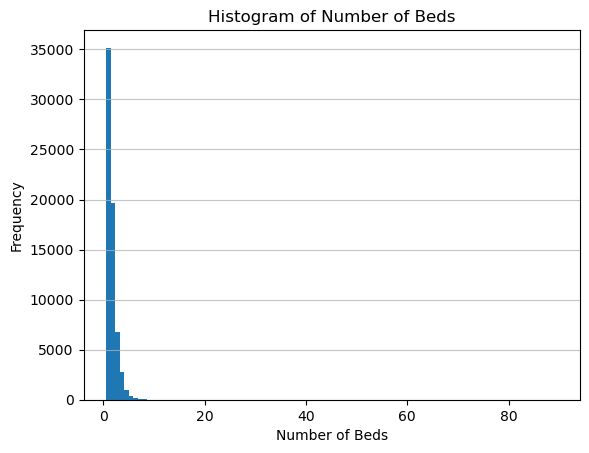

In [20]:
data.dropna(subset=["beds"],inplace=True)

print(data['beds'].astype(int).value_counts().sort_values())

# Plot histogram
plt.hist(data['beds'], bins=100, align='left')
plt.xlabel('Number of Beds')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Beds')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [21]:
data.loc[data['beds']>10,'beds'] = 10 # winsorize extreme value becuase extremely rare and not common
data.beds.describe()

count    66077.000000
mean         1.749580
std          1.060602
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: beds, dtype: float64

In [22]:
simp_reg_beds = smf.ols(formula="ln_price ~ beds", data=data).fit()
simp_reg_beds.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                 1.818e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:43   Log-Likelihood:                -64510.
No. Observations:               66077   AIC:                         1.290e+05
Df Residuals:                   66075   BIC:                         1.290e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3780      0.005    908.210      0.000       4.369       4.387
beds           0.3177      0.002    134.832      0.000       0.313       0.322
==============================================================================
Omnibus:                     5389.353   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10572.823
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                       4.608   Cond. No.                         4.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Bathrooms:

In [23]:
data.dropna(subset=["bathrooms_text"],inplace=True)

data.bathrooms_text.value_counts()


bathrooms_text
1 bath               48576
1.5 baths             4785
2 baths               4258
1 shared bath         2786
1 private bath        2739
2.5 baths             1031
3 baths                637
1.5 shared baths       359
Half-bath              240
3.5 baths              169
4 baths                106
0 baths                 69
2 shared baths          57
4.5 baths               42
Shared half-bath        35
0 shared baths          33
5 baths                 21
Private half-bath       18
6 baths                 11
2.5 shared baths        10
5.5 baths                6
3 shared baths           6
7 baths                  4
48 baths                 4
6.5 baths                3
49 baths                 2
7.5 baths                2
3.5 shared baths         2
6 shared baths           1
47 baths                 1
4 shared baths           1
10 baths                 1
5.5 shared baths         1
8.5 baths                1
Name: count, dtype: int64

In [24]:
# transfer into numerical
tmp = data.bathrooms_text
tmp = tmp.replace({'Shared half-bath':0.5, 'Half-bath':0.5})
tmp = tmp.str.extractall(r'(\d+(?:\.\d+)?)')
tmp.columns =['n_bath']
tmp = tmp.reset_index(level=1).drop('match',axis=1)
data = data.merge(tmp,left_index=True,right_index=True,how = 'outer', validate='one_to_one')
data.n_bath = data.n_bath.astype('float')
data.n_bath.value_counts().sort_index()

n_bath
0.0       102
1.0     54101
1.5      5144
2.0      4315
2.5      1041
3.0       643
3.5       171
4.0       107
4.5        42
5.0        21
5.5         7
6.0        12
6.5         3
7.0         4
7.5         2
8.5         1
10.0        1
47.0        1
48.0        4
49.0        2
Name: count, dtype: int64

In [25]:
data.loc[data['n_bath']>10,'n_bath'] = 10 # winsorize extreme value
data.n_bath.describe()

count    65724.000000
mean         1.164879
std          0.447782
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: n_bath, dtype: float64

In [26]:
simp_reg_bath = smf.ols(formula="ln_price ~ n_bath", data=data).fit()
simp_reg_bath.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                 1.441e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:44   Log-Likelihood:                -65470.
No. Observations:               65724   AIC:                         1.309e+05
Df Residuals:                   65722   BIC:                         1.310e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1376      0.007    580.877      0.000       4.124       4.152
n_bath         0.6852      0.006    120.054      0.000       0.674       0.696
==============================================================================
Omnibus:                     4995.542   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14720.648
Skew:                           0.405   Prob(JB):                         0.00
Kurtosis:                       5.172   Cond. No.                         5.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Review Scores Rating

In [27]:
data.dropna(subset=["review_scores_rating"],inplace=True)

data.review_scores_rating.describe()

count    52018.000000
mean         4.695698
std          0.425055
min          0.000000
25%          4.580000
50%          4.820000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

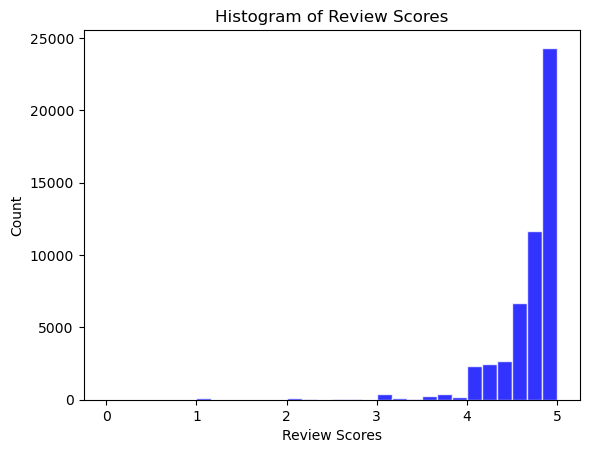

In [28]:
# plot histogram
plt.hist(data['review_scores_rating'], bins=30, color='blue', edgecolor='white', alpha=0.8)
plt.xlabel('Review Scores')
plt.ylabel('Count')
plt.title('Histogram of Review Scores')
plt.show()

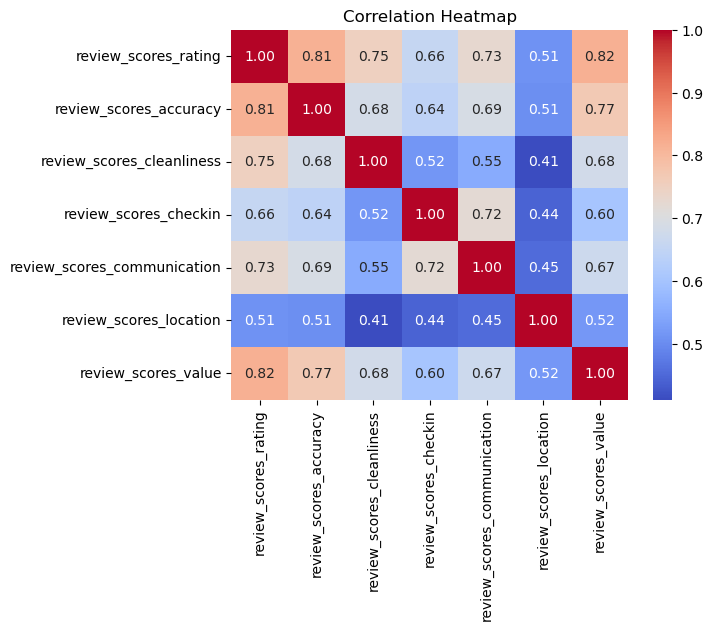

review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value


In [29]:
rscores = data.loc[:,[x for x in data.columns if 'review_scores' in x]]
correlation_matrix = rscores.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

list_review_names = [x for x in data.columns if 'review_scores' in x]
review_name_string = ' + '.join(list_review_names)
print(review_name_string)

In [30]:
simp_reg_review_score_rating = smf.ols(formula="ln_price ~ review_scores_rating", data=data).fit()
simp_reg_review_score_rating.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     621.0
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          2.90e-136
Time:                        22:56:45   Log-Likelihood:                -51734.
No. Observations:               52018   AIC:                         1.035e+05
Df Residuals:                   52016   BIC:                         1.035e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.0927      0.032    128.634      0.000       4.030       4.155
review_scores_rating     0.1682      0.007     24.919      0.000       0.155       0.181
==============================================================================
Omnibus:                     3208.631   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4498.398
Skew:                           0.550   Prob(JB):                         0.00
Kurtosis:                       3.931   Cond. No.                         54.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
data.dropna(subset=["review_scores_location"],inplace=True)

simp_reg_review_score_location = smf.ols(formula="ln_price ~ review_scores_location", data=data).fit()
simp_reg_review_score_location.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1031.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          6.02e-224
Time:                        22:56:45   Log-Likelihood:                -51508.
No. Observations:               52003   AIC:                         1.030e+05
Df Residuals:                   52001   BIC:                         1.030e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.5325      0.042     83.815      0.000       3.450       3.615
review_scores_location     0.2811      0.009     32.104      0.000       0.264       0.298
==============================================================================
Omnibus:                     3245.217   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4604.505
Skew:                           0.550   Prob(JB):                         0.00
Kurtosis:                       3.957   Cond. No.                         74.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
reg_review_score = smf.ols(formula="ln_price ~ review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value", data=data).fit()
reg_review_score.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     375.1
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:45   Log-Likelihood:                -50730.
No. Observations:               51998   AIC:                         1.015e+05
Df Residuals:                   51990   BIC:                         1.015e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       3.6621      0.047     77.276      0.000       3.569       3.755
review_scores_rating            0.2368      0.015     15.809      0.000       0.207       0.266
review_scores_accuracy         -0.1096      0.013     -8.141      0.000      -0.136      -0.083
review_scores_cleanliness       0.2438      0.009     26.670      0.000       0.226       0.262
review_scores_checkin          -0.0646      0.011     -5.809      0.000      -0.086      -0.043
review_scores_communication    -0.1429      0.013    -11.278      0.000      -0.168      -0.118
review_scores_location          0.2999      0.010     28.827      0.000       0.279       0.320
review_scores_value            -0.2047      0.012    -17.587      0.000      -0.228      -0.182
==============================================================================
Omnibus:                     3426.852   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5035.390
Skew:                           0.560   Prob(JB):                         0.00
Kurtosis:                       4.035   Cond. No.                         214.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Max/Min Nights

In [33]:
data.dropna(subset=["minimum_nights"],inplace=True)

data.minimum_nights.describe()

count    52003.000000
mean        35.126954
std         99.622997
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max       1000.000000
Name: minimum_nights, dtype: float64

In [34]:
# Remove extreme values (3 sigma principle)
minimum_nightsH = data.minimum_nights.mean()+3*data.minimum_nights.std()
minimum_nightsL = data.minimum_nights.mean()-3*data.minimum_nights.std()

outliers_nightsH = data.loc[(data.minimum_nights > minimum_nightsH)]
outliers_nightsL = data.loc[(data.minimum_nights < minimum_nightsL)]

print('The outliers above 3 std of the mean have mean and std:')
Outliers_nightsH_stats = outliers_nightsH['minimum_nights'].agg(['mean','std'])
display(OutliersH_stats)

print('The outliers below 3 std of the mean have mean and std:')
Outliers_nightsL_stats = outliers_nightsL['minimum_nights'].agg(['mean','std'])
display(OutliersL_stats)

data = data.loc[(data.minimum_nights < minimum_nightsH) & (data.minimum_nights > minimum_nightsL) ] # remove extreme value
data.minimum_nights.describe()

The outliers above 3 std of the mean have mean and std:


mean    5269.735149
std     6290.611988
Name: price, dtype: float64

The outliers below 3 std of the mean have mean and std:


mean   NaN
std    NaN
Name: price, dtype: float64

count    47775.000000
mean         5.821664
std         13.571957
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max        330.000000
Name: minimum_nights, dtype: float64

In [35]:
simp_reg_min_nights = smf.ols(formula="ln_price ~ minimum_nights", data=data).fit()
simp_reg_min_nights.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     828.0
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          1.56e-180
Time:                        22:56:45   Log-Likelihood:                -46813.
No. Observations:               47775   AIC:                         9.363e+04
Df Residuals:                   47773   BIC:                         9.365e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.9620      0.003   1546.177      0.000       4.956       4.968
minimum_nights    -0.0063      0.000    -28.775      0.000      -0.007      -0.006
==============================================================================
Omnibus:                     3111.856   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4490.145
Skew:                           0.561   Prob(JB):                         0.00
Kurtosis:                       3.998   Cond. No.                         16.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Host is Superhost:

In [36]:
data.dropna(subset=["host_is_superhost"],inplace=True)

data.host_is_superhost = [1 if x == "t" else 0 for x in data.host_is_superhost]
print(data.host_is_superhost.value_counts())


host_is_superhost
0    36978
1    10723
Name: count, dtype: int64


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\49987157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["host_is_superhost"],inplace=True)
C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\49987157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.host_is_superhost = [1 if x == "t" else 0 for x in data.host_is_superhost]


In [37]:
simp_reg_host_superhost = smf.ols(formula="ln_price ~ host_is_superhost", data=data).fit()
simp_reg_host_superhost.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     558.3
Date:                Tue, 05 Mar 2024   Prob (F-statistic):          1.01e-122
Time:                        22:56:45   Log-Likelihood:                -46872.
No. Observations:               47701   AIC:                         9.375e+04
Df Residuals:                   47699   BIC:                         9.377e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.8883      0.003   1454.167      0.000       4.882       4.895
host_is_superhost     0.1675      0.007     23.628      0.000       0.154       0.181
==============================================================================
Omnibus:                     3018.406   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4367.051
Skew:                           0.548   Prob(JB):                         0.00
Kurtosis:                       3.997   Cond. No.                         2.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Accomodates

In [38]:
data.dropna(subset=["accommodates"],inplace=True)
data.accommodates.describe()


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\3311307031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["accommodates"],inplace=True)


count    47701.000000
mean         3.127670
std          1.645899
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

In [39]:
simp_reg_accomodates = smf.ols(formula="ln_price ~ accommodates", data=data).fit()
simp_reg_accomodates.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                 2.132e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:45   Log-Likelihood:                -38336.
No. Observations:               47701   AIC:                         7.668e+04
Df Residuals:                   47699   BIC:                         7.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.2392      0.005    797.713      0.000       4.229       4.250
accommodates     0.2196      0.002    146.029      0.000       0.217       0.223
==============================================================================
Omnibus:                     3721.287   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8291.195
Skew:                           0.502   Prob(JB):                         0.00
Kurtosis:                       4.779   Cond. No.                         8.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
data['ln_accommodates'] = np.log(data['accommodates'])
simp_reg_ln_accomodates = smf.ols(formula="ln_price ~ ln_accommodates", data=data).fit()
simp_reg_ln_accomodates.summary()


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\3087858467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ln_accommodates'] = np.log(data['accommodates'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                 2.224e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:45   Log-Likelihood:                -38021.
No. Observations:               47701   AIC:                         7.605e+04
Df Residuals:                   47699   BIC:                         7.606e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1322      0.006    704.777      0.000       4.121       4.144
ln_accommodates     0.7753      0.005    149.136      0.000       0.765       0.786
==============================================================================
Omnibus:                     3858.811   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7917.989
Skew:                           0.543   Prob(JB):                         0.00
Kurtosis:                       4.675   Cond. No.                         4.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
#smf.ols(formula="ln_price ~ beds + accommodates + ln_accommodates", data=data).fit().summary()

## Number Of Reviews

In [42]:
data.dropna(subset=["number_of_reviews"],inplace=True)
data.number_of_reviews.describe()

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\1625781087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["number_of_reviews"],inplace=True)


count    47701.000000
mean        33.227542
std         63.467406
min          0.000000
25%          4.000000
50%         13.000000
75%         35.000000
max       2636.000000
Name: number_of_reviews, dtype: float64

In [43]:
simp_reg_nbr_reviews = smf.ols(formula="ln_price ~ number_of_reviews", data=data).fit()
simp_reg_nbr_reviews.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05776
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.810
Time:                        22:56:46   Log-Likelihood:                -47149.
No. Observations:               47701   AIC:                         9.430e+04
Df Residuals:                   47699   BIC:                         9.432e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.9256      0.003   1465.813      0.000       4.919       4.932
number_of_reviews  1.127e-05   4.69e-05      0.240      0.810   -8.07e-05       0.000
==============================================================================
Omnibus:                     2874.998   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4097.396
Skew:                           0.534   Prob(JB):                         0.00
Kurtosis:                       3.959   Cond. No.                         80.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
data['ln_number_of_reviews'] = np.log(data['number_of_reviews']+1e-10 )  # +1e-10 to avoid -inf
data.ln_number_of_reviews.describe()

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\255443301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ln_number_of_reviews'] = np.log(data['number_of_reviews']+1e-10 )  # +1e-10 to avoid -inf


count    47701.000000
mean         2.469759
std          1.815602
min        -23.025851
25%          1.386294
50%          2.564949
75%          3.555348
max          7.877018
Name: ln_number_of_reviews, dtype: float64

In [45]:
smf.ols(formula="ln_price ~ ln_number_of_reviews+number_of_reviews", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     26.07
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           4.83e-12
Time:                        22:56:46   Log-Likelihood:                -47123.
No. Observations:               47701   AIC:                         9.425e+04
Df Residuals:                   47698   BIC:                         9.428e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.8980      0.005    962.456      0.000       4.888       4.908
ln_number_of_reviews     0.0142      0.002      7.217      0.000       0.010       0.018
number_of_reviews       -0.0002   5.62e-05     -3.788      0.000      -0.000      -0.000
==============================================================================
Omnibus:                     2929.880   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4182.708
Skew:                           0.541   Prob(JB):                         0.00
Kurtosis:                       3.966   Cond. No.                         128.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Availability

id
3109                   30
5396                    0
7397                   11
7964                    0
9952                    0
10586                   0
10588                  49
11265                   0
11487                   1
11798                  51
12452                  25
12887                  41
16455                   6
16626                  43
17287                  29
17994                  60
21004                  48
21419                  34
22158                  42
22979                   4
23441                   0
24260                   3
26562                   0
26827                   0
27008                   0
27288                   3
27967                   1
31435                  48
32082                   0
33114                   0
33814                  11
35065                  24
36490                   0
36586                   0
38303                   8
38650                  18
39651                   9
39666                  54
39948    

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\3413961704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=["availability_60"],inplace=True)


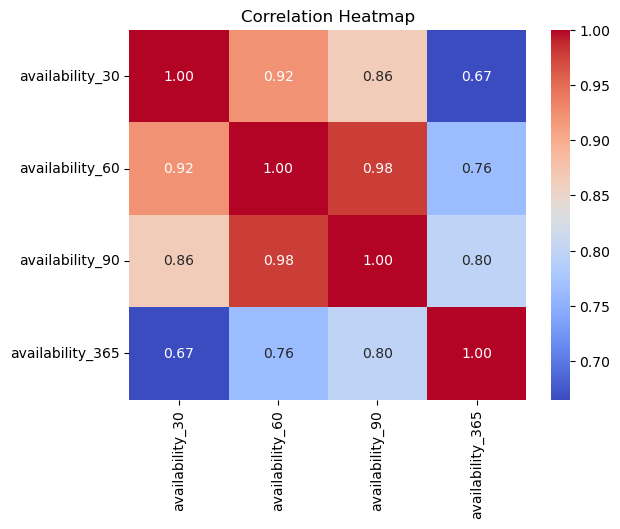

In [46]:
display(data['availability_60'])
data.dropna(subset=["availability_60"],inplace=True)

availability = data.loc[:,[x for x in data.columns if 'availability_' in x]]
correlation_matrix_avail = availability.corr()
sns.heatmap(correlation_matrix_avail, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [47]:
simp_reg_availability = smf.ols(formula="ln_price ~ availability_60", data=data).fit()
simp_reg_availability.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1605.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:46   Log-Likelihood:                -46360.
No. Observations:               47701   AIC:                         9.272e+04
Df Residuals:                   47699   BIC:                         9.274e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.8227      0.004   1236.439      0.000       4.815       4.830
availability_60     0.0056      0.000     40.066      0.000       0.005       0.006
==============================================================================
Omnibus:                     3019.062   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4266.871
Skew:                           0.557   Prob(JB):                         0.00
Kurtosis:                       3.952   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary of simple regression of Features

In [48]:
models = [simp_reg_neighborhoods, simp_reg_entire_rooms, simp_reg_beds, simp_reg_bath, simp_reg_review_score_rating, 
 simp_reg_review_score_location, reg_review_score, simp_reg_min_nights, simp_reg_host_superhost, simp_reg_accomodates,
 simp_reg_ln_accomodates, simp_reg_nbr_reviews, simp_reg_availability ] # Add more models to this list as needed

model_names = []

for model in models:
    model_name = str(model).split(' ')[1]
    model_names.append(model_name)

# Initialize a list to store the statistics
model_stats = []

for model, name in zip(models, model_names):
    stats = {
        'Model': name,
        'Adj. R²': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic,
    }
    model_stats.append(stats)

df_stats = pd.DataFrame(model_stats)
print(df_stats)

#print(data.shape[0])
#data.dropna(Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + review_scores_location + number_of_reviews + availability_60 + host_is_superhost"


     Model   Adj. R²            AIC            BIC
0   object  0.087039  140727.749007  140909.909411
1   object  0.031049  144680.032570  144698.248610
2   object  0.215758  129024.458582  129042.655734
3   object  0.179847  130943.654774  130961.841213
4   object  0.011778  103472.928933  103490.647623
5   object  0.019416  103019.538212  103037.256325
6   object  0.047943  101475.225151  101546.096835
7   object  0.017016   93630.970323   93648.518838
8   object  0.011548   93747.539994   93765.085410
9   object  0.308932   76675.273419   76692.818834
10  object  0.317991   76045.809506   76063.354921
11  object -0.000020   94302.546660   94320.092075
12  object  0.032539   92723.649791   92741.195206


## First Model

In [49]:
data=data.dropna(subset=["Entire_room", "accommodates", "beds", "n_bath", "minimum_nights", "review_scores_rating", "review_scores_location", "number_of_reviews", "availability_60", "host_is_superhost"])
formula_string_1 = "ln_price ~ Entire_room + accommodates +minimum_nights+ review_scores_rating + availability_60"
formula_string_1_neighborhood = "ln_price ~ Entire_room + accommodates +minimum_nights+ review_scores_rating + availability_60 + Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant"

formula_string_2 = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + availability_60"
formula_string_2_neighborhood = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + availability_60 + Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant"

formula_string_3 = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + availability_60 + host_is_superhost"
formula_string_3_neighborhood = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + availability_60 + host_is_superhost + Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant"

formula_string_4 = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + review_scores_location + number_of_reviews + availability_60 + host_is_superhost"
formula_string_4_neighborhood = "ln_price ~ Entire_room + accommodates + beds + n_bath +minimum_nights+ review_scores_rating + review_scores_location + number_of_reviews + availability_60 + host_is_superhost + Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant"

#formula_string_final ="ln_price ~ Entire_room +beds+number_of_reviews+accommodates+n_bath+host_is_superhost+minimum_nights+review_scores_rating+review_scores_location+ Observatoire + Hôtel_de_Ville + Entrepôt + Popincourt + Louvre + Bourse + Gobelins + Luxembourg + Buttes_Chaumont + Reuilly + Élysée + Panthéon + Batignolles_Monceau + Vaugirard + Opéra + Palais_Bourbon + Passy + Temple + Ménilmontant+ availability_60"

models_string_final = [formula_string_1, formula_string_2, formula_string_3,  formula_string_4, 
                       formula_string_1_neighborhood, formula_string_2_neighborhood, formula_string_3_neighborhood, formula_string_4_neighborhood]


# Initialize a list to store the statistics
model_stats = []

for model_string in models_string_final:

    temp_mod = smf.ols(formula= model_string, data=data).fit()

    stats = {
        'Adj. R²': temp_mod.rsquared_adj,
        'AIC': temp_mod.aic,
        'BIC': temp_mod.bic,
    }
    model_stats.append(stats)

df_stats = pd.DataFrame(model_stats)
print(df_stats)

    Adj. R²           AIC           BIC
0  0.372346  71589.007889  71641.618294
1  0.394003  69923.226717  69993.373923
2  0.399941  69456.538898  69535.454505
3  0.409060  68731.209738  68827.662146
4  0.447973  65509.921839  65729.131858
5  0.463931  64118.648708  64355.395529
6  0.467613  63792.293292  64037.808514
7  0.470820  63507.359505  63770.411528


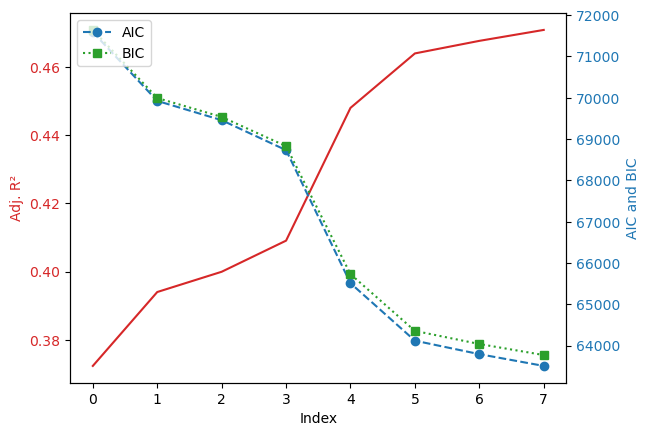

In [50]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot Adj. R² on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Index')
ax1.set_ylabel('Adj. R²', color=color)
ax1.plot(df_stats.index, df_stats['Adj. R²'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for AIC and BIC
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('AIC and BIC', color=color)
ax2.plot(df_stats.index, df_stats['AIC'], color=color, marker='o', linestyle='--', label='AIC')
ax2.plot(df_stats.index, df_stats['BIC'], color='tab:green', marker='s', linestyle=':', label='BIC')
ax2.tick_params(axis='y', labelcolor=color)

# Set the legend
ax2.legend(loc='upper left')

# Display the plot
plt.show()


In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf

def evaluate_model(model_string, data):
    y_names = model_string.split("~")[0].strip()
    x_names = model_string.split("~")[1].split("+")
    x_names = [name.strip() for name in x_names if name.strip()]
    
    # Extract features for the model
    X = data[x_names]
    y = data[y_names]
    
    # Initialize lists to store the RMSE for each fold
    ols_rmse_values = []
    lasso_rmse_values = []
    ridge_rmse_values = []
    
    # Define the number of folds for cross-validation
    n_folds = 5
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the OLS model on the training set
        ols_model = smf.ols(formula=model_string, data=pd.concat([y_train, X_train], axis=1)).fit()
        ols_predictions = ols_model.predict(X_test)
        ols_rmse = np.sqrt(mean_squared_error(y_test, ols_predictions))
        ols_rmse_values.append(ols_rmse)
        
        # Fit the LASSO model on the training set
        # Note: You need to convert the data to a format compatible with sklearn for LASSO and Ridge
        from sklearn.linear_model import Lasso
        lasso = Lasso(alpha=0.1) # Adjust alpha as needed
        lasso.fit(X_train, y_train)
        lasso_predictions = lasso.predict(X_test)
        lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))
        lasso_rmse_values.append(lasso_rmse)
        
        # Fit the Ridge model on the training set
        from sklearn.linear_model import Ridge
        ridge = Ridge(alpha=0.1) # Adjust alpha as needed
        ridge.fit(X_train, y_train)
        ridge_predictions = ridge.predict(X_test)
        ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
        ridge_rmse_values.append(ridge_rmse)
    
    # Calculate the average RMSE for each model type
    ols_rmse_avg = np.mean(ols_rmse_values)
    lasso_rmse_avg = np.mean(lasso_rmse_values)
    ridge_rmse_avg = np.mean(ridge_rmse_values)
    
    # Collect stats
    stats = {
        'Model': model_string,
        'OLS Average RMSE': ols_rmse_avg,
        'LASSO Average RMSE': lasso_rmse_avg,
        'Ridge Average RMSE': ridge_rmse_avg,
    }
    
    return stats

# Assuming data is your DataFrame and it's already preprocessed
# Evaluate each model
model_stats_2 = []
for model_string in models_string_final:
    model_stats_2.append(evaluate_model(model_string, data))

# Convert to DataFrame
df_stats_2 = pd.DataFrame(model_stats_2)
print(df_stats_2)


                                               Model  OLS Average RMSE  \
0  ln_price ~ Entire_room + accommodates +minimum...          0.514119   
1  ln_price ~ Entire_room + accommodates + beds +...          0.505185   
2  ln_price ~ Entire_room + accommodates + beds +...          0.502733   
3  ln_price ~ Entire_room + accommodates + beds +...          0.498940   
4  ln_price ~ Entire_room + accommodates +minimum...          0.482248   
5  ln_price ~ Entire_room + accommodates + beds +...          0.475253   
6  ln_price ~ Entire_room + accommodates + beds +...          0.473634   
7  ln_price ~ Entire_room + accommodates + beds +...          0.472240   

   LASSO Average RMSE  Ridge Average RMSE  
0            0.531874            0.514119  
1            0.531874            0.505185  
2            0.531874            0.502733  
3            0.531517            0.498940  
4            0.531874            0.482248  
5            0.531874            0.475253  
6            0.531874    

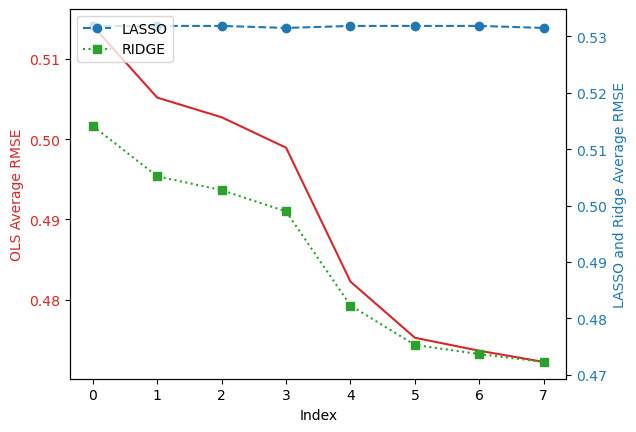

In [52]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot Adj. R² on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Index')
ax1.set_ylabel('OLS Average RMSE', color=color)
ax1.plot(df_stats_2.index, df_stats_2['OLS Average RMSE'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for AIC and BIC
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('LASSO and Ridge Average RMSE', color=color)
ax2.plot(df_stats_2.index, df_stats_2['LASSO Average RMSE'], color=color, marker='o', linestyle='--', label='LASSO')
ax2.plot(df_stats_2.index, df_stats_2['Ridge Average RMSE'], color='tab:green', marker='s', linestyle=':', label='RIDGE')
ax2.tick_params(axis='y', labelcolor=color)

# Set the legend
ax2.legend(loc='upper left')

# Display the plot
plt.show()

In [53]:
model_1 = smf.ols(formula= formula_string_4_neighborhood, data=data).fit()
model_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     1458.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:52   Log-Likelihood:                -31724.
No. Observations:               47496   AIC:                         6.351e+04
Df Residuals:                   47466   BIC:                         6.377e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.8410      0.036     78.877      0.000       2.770       2.912
Observatoire[T.True]            0.0072      0.013      0.544      0.586      -0.019       0.033
Hôtel_de_Ville[T.True]          0.3740      0.013     27.845      0.000       0.348       0.400
Entrepôt[T.True]                0.0796      0.010      7.715      0.000       0.059       0.100
Popincourt[T.True]              0.0432      0.010      4.423      0.000       0.024       0.062
Louvre[T.True]                  0.4523      0.015     29.458      0.000       0.422       0.482
Bourse[T.True]                  0.2284      0.013     17.547      0.000       0.203       0.254
Gobelins[T.True]               -0.0775      0.014     -5.637      0.000      -0.104      -0.051
Luxembourg[T.True]              0.3872      0.015     26.617      0.000       0.359       0.416
Buttes_Chaumont[T.True]        -0.1659      0.011    -14.944      0.000      -0.188      -0.144
Reuilly[T.True]                -0.0434      0.013     -3.381      0.001      -0.069      -0.018
Élysée[T.True]                  0.3581      0.014     25.177      0.000       0.330       0.386
Panthéon[T.True]                0.2705      0.014     19.702      0.000       0.244       0.297
Batignolles_Monceau[T.True]     0.0675      0.011      6.143      0.000       0.046       0.089
Vaugirard[T.True]               0.1317      0.010     12.583      0.000       0.111       0.152
Opéra[T.True]                   0.2116      0.012     17.736      0.000       0.188       0.235
Palais_Bourbon[T.True]          0.4311      0.015     29.006      0.000       0.402       0.460
Passy[T.True]                   0.2630      0.012     22.160      0.000       0.240       0.286
Temple[T.True]                  0.2765      0.012     23.043      0.000       0.253       0.300
Ménilmontant[T.True]           -0.1567      0.011    -13.929      0.000      -0.179      -0.135
Entire_room                     0.2844      0.007     41.164      0.000       0.271       0.298
accommodates                    0.1362      0.003     52.158      0.000       0.131       0.141
beds                            0.0436      0.004     11.375      0.000       0.036       0.051
n_bath                          0.2058      0.006     33.771      0.000       0.194       0.218
minimum_nights                 -0.0064      0.000    -39.437      0.000      -0.007      -0.006
review_scores_rating            0.1567      0.006     24.473      0.000       0.144       0.169
review_scores_location          0.0413      0.008      4.861      0.000       0.025       0.058
number_of_reviews              -0.0006   3.54e-05    -16.368      0.000      -0.001      -0.001
availability_60                 0.0042      0.000     39.723      0.000       0.004       0.004
host_is_sup

# Tests

## Breush Pagan Test

In [54]:
# Perform the Breusch-Pagan test
def bpTest(model):
    breusch_pagan_test = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
    print("Breusch-Pagan Test:")
    print("Lagrange multiplier statistic:", breusch_pagan_test[0])
    print("p-value:", breusch_pagan_test[1])
    print("f-value:", breusch_pagan_test[2])
    print("f p-value:", breusch_pagan_test[3])

bpTest(model_1)

Breusch-Pagan Test:
Lagrange multiplier statistic: 1888.6787064394596
p-value: 0.0
f-value: 67.78102872080427
f p-value: 0.0


In [55]:
# Change the standard errors with HC3:
model_1_hc = smf.ols(formula = formula_string_4_neighborhood, data=data).fit(cov_type='HC3')
model_1_hc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     1044.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:52   Log-Likelihood:                -31724.
No. Observations:               47496   AIC:                         6.351e+04
Df Residuals:                   47466   BIC:                         6.377e+04
Df Model:                          29                                         
Covariance Type:                  HC3                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.8410      0.044     64.233      0.000       2.754       2.928
Observatoire[T.True]            0.0072      0.013      0.565      0.572      -0.018       0.032
Hôtel_de_Ville[T.True]          0.3740      0.014     27.285      0.000       0.347       0.401
Entrepôt[T.True]                0.0796      0.010      7.957      0.000       0.060       0.099
Popincourt[T.True]              0.0432      0.010      4.535      0.000       0.025       0.062
Louvre[T.True]                  0.4523      0.015     29.338      0.000       0.422       0.482
Bourse[T.True]                  0.2284      0.013     17.402      0.000       0.203       0.254
Gobelins[T.True]               -0.0775      0.014     -5.728      0.000      -0.104      -0.051
Luxembourg[T.True]              0.3872      0.017     23.411      0.000       0.355       0.420
Buttes_Chaumont[T.True]        -0.1659      0.011    -15.706      0.000      -0.187      -0.145
Reuilly[T.True]                -0.0434      0.012     -3.525      0.000      -0.068      -0.019
Élysée[T.True]                  0.3581      0.016     22.631      0.000       0.327       0.389
Panthéon[T.True]                0.2705      0.014     19.230      0.000       0.243       0.298
Batignolles_Monceau[T.True]     0.0675      0.011      6.102      0.000       0.046       0.089
Vaugirard[T.True]               0.1317      0.011     12.295      0.000       0.111       0.153
Opéra[T.True]                   0.2116      0.012     17.889      0.000       0.188       0.235
Palais_Bourbon[T.True]          0.4311      0.016     26.373      0.000       0.399       0.463
Passy[T.True]                   0.2630      0.013     20.814      0.000       0.238       0.288
Temple[T.True]                  0.2765      0.012     23.200      0.000       0.253       0.300
Ménilmontant[T.True]           -0.1567      0.010    -15.305      0.000      -0.177      -0.137
Entire_room                     0.2844      0.008     33.906      0.000       0.268       0.301
accommodates                    0.1362      0.003     45.572      0.000       0.130       0.142
beds                            0.0436      0.004      9.900      0.000       0.035       0.052
n_bath                          0.2058      0.014     14.805      0.000       0.179       0.233
minimum_nights                 -0.0064      0.000    -22.435      0.000      -0.007      -0.006
review_scores_rating            0.1567      0.007     21.234      0.000       0.142       0.171
review_scores_location          0.0413      0.010      4.235      0.000       0.022       0.060
number_of_reviews              -0.0006   4.64e-05    -12.489      0.000      -0.001      -0.000
availability_60                 0.0042      0.000     36.908      0.000       0.004       0.004
host_is_sup

## VIF Test

In [56]:
def calculate_vif(data, formula_string):
    # Create design matrices
    y, X = dmatrices(formula_string, data=data, return_type='dataframe')

    # Calculate VIF for each predictor variable
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data['VIF < 5'] = vif_data['VIF'].apply(lambda x: x < 5)

    return vif_data

display(calculate_vif(data, formula_string_4_neighborhood))


,Variable,VIF,VIF < 5
0,Intercept,276.533626,False
1,Observatoire[T.True],1.293715,True
2,Hôtel_de_Ville[T.True],1.326573,True
3,Entrepôt[T.True],1.555114,True
4,Popincourt[T.True],1.699860,True
5,Louvre[T.True],1.234422,True
6,Bourse[T.True],1.345546,True
7,Gobelins[T.True],1.260687,True
8,Luxembourg[T.True],1.267134,True
9,Buttes_Chaumont[T.True],1.439478,True


In [57]:
def perform_reset_test(model, data, Q):
    # Get the predicted values and squared predicted values up to the power Q
    predicted_values = model.fittedvalues
    data['predicted_values'] = model.predict(data)
    data = data.dropna(subset=["predicted_values"])
    
    # Create a DataFrame with the squared predicted values up to the power Q
    squared_predicted_values = [predicted_values**(i+1) for i in range(Q+1)]
    auxiliary_data = pd.concat(squared_predicted_values, axis=1)
    
    # Add a constant to the auxiliary data
    auxiliary_data = sm.add_constant(auxiliary_data)
    
    # Fit the auxiliary regression
    auxiliary_model = sm.OLS(data["ln_price"].values, auxiliary_data).fit()
    
    # Perform the RESET test
    reset_test_results = auxiliary_model.f_test
    
    # Print the summary of the auxiliary model
    print(auxiliary_model.summary())
    
    # Print the RESET test p-value
    print("RESET test p-value:", reset_test_results)

perform_reset_test(model_1_hc, data, 3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:56:54   Log-Likelihood:                -31116.
No. Observations:               47496   AIC:                         6.224e+04
Df Residuals:                   47491   BIC:                         6.229e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.1678      1.786     15.208      0.0

C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\3461245631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_values'] = model.predict(data)


C:\Users\Vitanie\AppData\Local\Temp\ipykernel_25108\2647644360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predicted_ln_values'] = model_1_hc.predict(data)


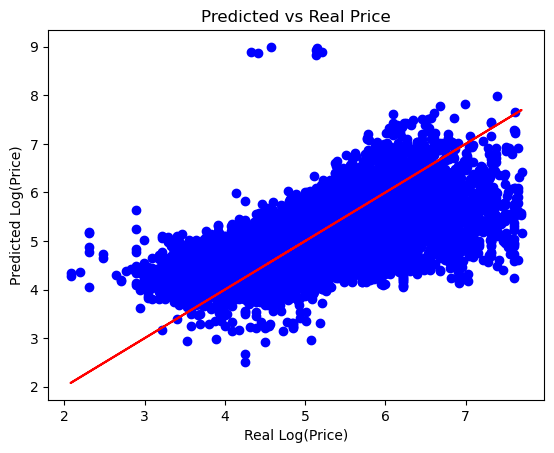

In [58]:
#plot log predicted and log real values
data['predicted_ln_values'] = model_1_hc.predict(data)
data=data.dropna(subset=["predicted_ln_values"])
data['real_ln_values'] = data['ln_price']
plt.scatter(data['real_ln_values'], data['predicted_ln_values'], color='blue')
plt.plot(data['real_ln_values'], data['real_ln_values'], color='red')
plt.xlabel('Real Log(Price)')
plt.ylabel('Predicted Log(Price)')
plt.title('Predicted vs Real Price')
plt.show()

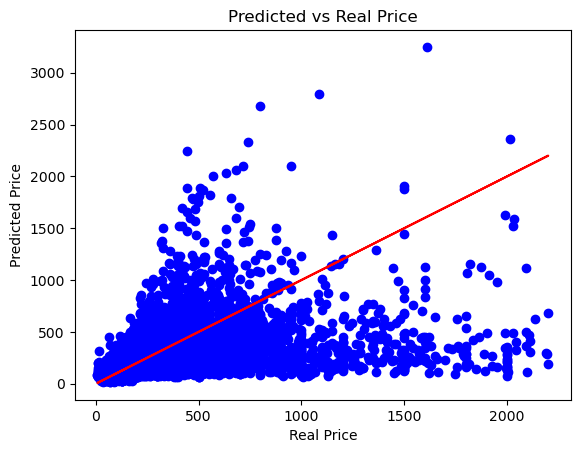

In [59]:
#plot predicted and real values

s_squared = (model_1_hc.resid**2).sum()/data.shape[0]

data['predicted_values'] = np.exp(model_1_hc.predict(data)+0.5*s_squared)
ITD = data[data['predicted_values'] > 5000].index
data.drop(ITD, inplace=True)
data=data.dropna(subset=["predicted_values"])
data['real_values'] = data['price']
plt.scatter(data['real_values'], data['predicted_values'], color='blue')
plt.plot(data['real_values'], data['real_values'], color='red')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Real Price')
plt.show()